In [93]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

In [94]:
df=pd.read_csv('25_May.csv')

# Cleaning plan
* While collecting the data, some "location" codes were updated after few days.
     * Overwrite all previous instances of the location to the new location code.
* For the initial days, "points_flowering" was not being used. Consider this attribute from 19 march onwards.
     * For days after 19 Mar, replace nan with 0.
     * Transitions "->" can be summarised in a different table to check inference for many vines initiating new point flowering together (these points were discovered but in dormant state).
     * In main table, only the current number of active flowering points (transitioned value of '->'), is relevant.
* "Total_points" transitions "->" can be summarised in a different table. 
     * The main table, must only have the total number, for all fields. This is the 'Type'.
     * Dates of transition may be studied later for indiicating when new points were discovered/observed
* "Total_flowers" which was used for stock checks is relevant only for the last day "25 May"
     

In [95]:
df.head()

,Date,Location,Total points,Points flowering,New flowers,Total Flowers
0,12 Mar 20,3*2ag,8,NaN,0.0,NaN
1,12 Mar 20,3*3g,2,NaN,NaN,NaN
2,12 Mar 20,4*3a,9,NaN,1.0,NaN
3,12 Mar 20,4*2a,8,NaN,NaN,NaN
4,12 Mar 20,5*2a,1,NaN,NaN,NaN


In [96]:
# Replace the spaces in the column names
df.columns=df.columns.str.replace(' ','_') #Rename columns to remove blank space
df.columns

Index(['Date', 'Location', 'Total_points', 'Points_flowering', 'New_flowers',
       'Total_Flowers'],
      dtype='object')

In [97]:
# check unique locations
df1=df.copy(deep=True) #make copy to preserve original dataframe 
df1['Location'].unique()

array(['3*2ag', '3*3g', '4*3a', '4*2a', '5*2a', '5*2ag', '4*3a2g', '5*4a',
       '5*4as', '6*5a', '7*3as', '7*3a', '7*2a', '7*a', '6*2a', '7*c',
       '9*2a', '8*d', '8*3a', '8*3a2s', '10*as', '11*g', '12*g', '13*g',
       '8*4a', '8*4a2s', '12*2ag', '15*2d', '17*a', '19*d', '20*a',
       '23*3a', '10*s', '21*g', '7*3a3s', '7*3a2s', '10*2a', '16*m',
       '5*3as', '19*2d', '25*3g', '19*m', '17*m', '18*g', '1*4a', '2*5a',
       '18*m', '19*s', '19*s->19*m', '19*m->19*2m', '19*2m', '12*m',
       '12*2a', '12*2g', '11*a', '12*2a->12*a', '12*a', '8*2d',
       '10*s -> 10*m', '10*2m', '10*as->10*2m', '10*2m->10*3m'],
      dtype=object)

In [98]:
# Number of unique locations before cleaning (including transitions)
len(df1['Location'].unique())

62

## "Location" column cleaning algorithm
Since location code depended on relative tree position, some codes were updated on later date to represent location more clearly. These tranistioned locations have to be regularised to the most recent code.
* Iterate from bottom to top since changes apply to all preceding instances.
* When a "a->b" occurs, for all preceding index locations containing a, replace with b.
* At the transitioning "->" locations retain only the updated value.

Observations:
- Some transitions had a space: 10*s->' '10*m. 

In [99]:
# On what dates did the location update (transitions) happen
df1[df1['Location'].str.contains('->')]
#Notice how some transitions have a space 10*s-> 10*m

,Date,Location,Total_points,Points_flowering,New_flowers,Total_Flowers
1538,23 Apr 20,19*s->19*m,1,1,0.0,NaN
1543,23 Apr 20,19*m->19*2m,2,2,2.0,NaN
1720,27 Apr 20,12*2a->12*a,2,0,0.0,NaN
2937,21 May 20,10*s -> 10*m,9,0,0.0,NaN
2989,22 May 20,10*s -> 10*m,9,0,0.0,NaN
3041,23 May 20,10*s -> 10*m,9,0,0.0,NaN
3042,23 May 20,10*as->10*2m,7,0,0.0,NaN
3044,23 May 20,10*2m->10*3m,1,1,1.0,NaN
3093,24 May 20,10*s -> 10*m,9,0,0.0,NaN
3094,24 May 20,10*as->10*2m,7,0,0.0,NaN


In [100]:
df1['Location']=df1['Location'].str.replace(' ','') #remove blank space in location column

In [101]:
for indi, rowi in df1[::-1].iterrows(): #iterate the rows from bottom to top
    if '->' in rowi['Location']:
        a=df1.loc[indi,'Location'].split('->')[0]
        b=df1.loc[indi,'Location'].split('->')[1]
        df1.at[indi,'Location']=b #update transitions to second value
        for indj, rowj in df1[indi:None:-1].iterrows():  #from transitioned value, change all previous references
            if rowj['Location']==a:
                df1.at[indj,'Location']=b    #use ".at" since iterrows uses a copy which will not update original value

#There may be redundant locs to identify and remove due to this.

In [102]:
df1['Location'].unique() #check if all locations are unique and not transitioning.
len(df1['Location'].unique()) #54 locs after cleaning. 

54

In [103]:
#Check which locations are not flowering and remove these redundant locs.
a1=df1.replace(0,np.nan)
a=a1.groupby(['Location'])['New_flowers'].count()
a=pd.DataFrame(a)
a.reset_index(inplace=True)
a.rename(columns={'New_flowers': 'Days'}, inplace=True)
a[a['Days']==0] #locations which have '0' flowering days

redun_locs=list(a[a['Days']==0]['Location']) # 4 locs 10*2m,7*c, 8*3a, 8*3a2s are not flowering. 

df1=df1[~df1['Location'].isin(redun_locs)]

In [104]:
len(df1['Location'].unique()) #50 locs after removing redundant locs

50

#### Check 'Total_points' column 

In [105]:
# Remove duplcite values of transition, keeping preserving only the first date of the transition
df1[df1['Total_points'].str.contains('->', na=False)].drop_duplicates(subset=['Location','Total_points'], keep='first')
#After inserting dictionary of "rain/irrigated" check correlation of new flowering points through "Total_points" 

,Date,Location,Total_points,Points_flowering,New_flowers,Total_Flowers
147,19 Mar 20,6*2a,2->1,0,0.0,NaN
349,25 Mar 20,7*3a,5->2,2,0.0,NaN
356,25 Mar 20,10*m,6->8,0,0.0,NaN
358,25 Mar 20,10*3m,2->3,0,0.0,NaN
360,25 Mar 20,11*g,2->3,0,0.0,NaN
400,26 Mar 20,15*2d,1->2,1,0.0,NaN
421,27 Mar 20,8*4a2s,2->3,0,0.0,NaN
426,27 Mar 20,7*2a,1->2,1,0.0,NaN
447,28 Mar 20,4*3a2g,11->12,0,0.0,NaN
470,28 Mar 20,10*3m,3->6,0,0.0,NaN


#### Check 'Points_flowering' column 

In [106]:
# Unique dates on which new flowering points transitioned up or down
df1[df1['Points_flowering'].str.contains('->', na=False)].drop_duplicates(subset=['Location','Points_flowering'],keep='first')

,Date,Location,Total_points,Points_flowering,New_flowers,Total_Flowers
493,29 Mar 20,5*4a,9,5->6,9.0,NaN
522,30 Mar 20,3*2ag,8,3->5,4.0,NaN
638,2 Apr 20,4*3a2g,12,1->5,5.0,NaN
639,2 Apr 20,4*3a,9,2->4,4.0,NaN
640,2 Apr 20,4*2a,9,2->3,2.0,NaN
...,...,...,...,...,...,...
2882,20 May 20,8*2d,2,1->0,0.0,NaN
2902,20 May 20,18*g,8,4->3,3.0,NaN
2942,21 May 20,12*m,2,1->0,0.0,NaN
3058,23 May 20,18*g,8,3->2,2.0,NaN


In [107]:
# Export cleaned table to csv
## Characteristics of the 'Clean_table':
### Location transitions have been cleaned and redundant locs removed. 50 flowering locs.
### Preserves the date of transition in 'total_points' and 'points_flowering'. These dates contain'->'.
df1.to_csv('Clean_table.csv',index=False)

# Visualizations

In [108]:
#Display the day with max new flowers:
df1=pd.read_csv('Clean_table.csv')
desc_maxflowers=pd.DataFrame(df1.groupby('Date')['New_flowers'].sum()).sort_values('New_flowers',ascending=False)
maxflow_date=desc_maxflowers.index[0]
max_date=df1[df1['Date']== maxflow_date]
#len(max_date)
#max_date
# type(df1['New_flowers'][2])

#Number of locations which have atleast 1 flower
seas_locs=len(max_date[max_date['New_flowers'] != 0]) # 40 locs; Total locs is 62; 62 is still a much smaller part of total grid.
max_date.sort_values('New_flowers',ascending=False,inplace=True) # Sort the locs in desc order of flowers

#Number of locs which cumulate to 80%
max_date['flow_cumul']=max_date['New_flowers'].cumsum()
eigtper=max_date['flow_cumul'].iloc[-1]*0.8 #Value of 80% of the flowers
len(max_date[max_date['flow_cumul']<eigtper]) # 19 locs

19

In [109]:
#Create new cols for each date: Flowering locs(>0);Eighty_perc_locs
## O/p df Date; Total flowers; Flow_locs; eighty_locs


#Function for counting locations which are flowering "Flow_locs"
def flocs(x):
    l=len(x[x!=0.0])#transform takes 'x' as the column x['a'] (series)
    return(l)

#Function for counting minimum no. of locs which have 80% of flowers
def eigtlocs(x):
    y=x.sort_values(ascending=False) #sort in descending to get min locations having max flowers
    c=y.cumsum()
    eightper=c.iloc[-1]*0.8
    l=len(c[c<eightper])
    return(l)
    
df2=df1.copy()
df2['Total_New']=df2.groupby('Date')['New_flowers'].transform(sum) #New col with sum of flowers each day
#df2[df2['Date']== '23 Apr 20']
df2['Flow_locs']=df2.groupby('Date')['New_flowers'].transform(flocs)
df2['Eighty_perc_locs']=df2.groupby('Date')['New_flowers'].transform(eigtlocs)
#df2[df2['Date']== '22 Apr 20'] # For testing against max_flower_date from previous code block

#Clean table grouped by our relevant columns
perc_opt=df2.groupby('Date',sort=False)[['Total_New','Flow_locs','Eighty_perc_locs']].mean()

#Column for focus percentage of locations having 80% of total flowers
perc_opt['day_foc_perc']=perc_opt['Eighty_perc_locs']/perc_opt['Flow_locs']*100

perc_opt.head()
#perc_opt[perc_opt.index=='22 Apr 20']
round(perc_opt['day_foc_perc'].mean(),1) # Mean focus percentage. #49.5%

49.5

In [110]:
#There are more optimisation figures which may be relevant:
## 80% holding locs compared with flowering locs of the day : day_foc_perc
## 80% holding locs compared with total flowering locs : seas_foc_perc
## 80% holding locs compared with full walking path(checking for new locs) : grid_foc_perc
perc_opt['day_foc_perc']=perc_opt['Eighty_perc_locs']/perc_opt['Flow_locs']*100
perc_opt['seas_foc_perc']=perc_opt['Eighty_perc_locs']/seas_locs*100
perc_opt['grid_foc_perc']=perc_opt['Eighty_perc_locs']/80*100
perc_opt[perc_opt.index=='22 Apr 20']

,Total_New,Flow_locs,Eighty_perc_locs,day_foc_perc,seas_foc_perc,grid_foc_perc
Date,,,,,,
22 Apr 20,138.0,40,19,47.5,47.5,23.75


In [111]:
# Visualise date vs foc_perc

## Total new flowers per day across season


<AxesSubplot:xlabel='Date', ylabel='New_flowers'>

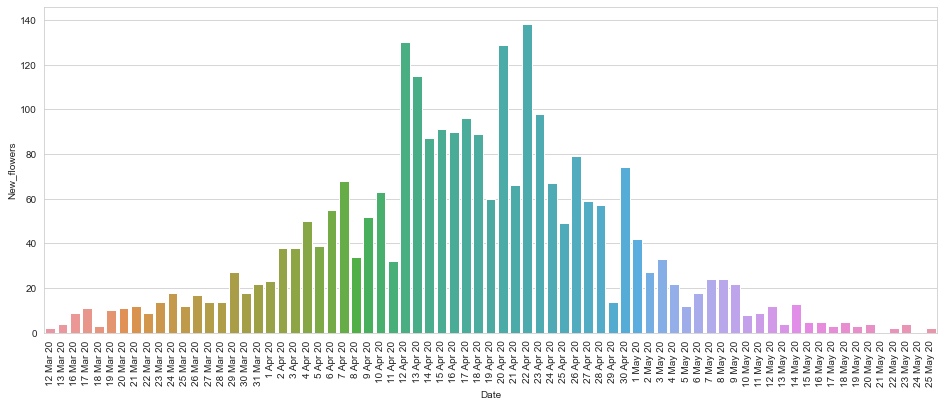

In [112]:
plt.figure(figsize=(16,6))
plt.xticks(rotation=90)
#sns.catplot(x='Date', y='New_flowers',data=df1,estimator=sum, kind='bar', ci= False, palette='Blues_r')
sns.barplot(x='Date', y='New_flowers',data=df1,estimator=sum, ci= False, )

### Remove transitions in 'Total_points' column

In [113]:
# Convert 'Total_points' column to reflect only updated count
df2=df1.copy(deep=True) #save all previous transformations 
df2['Total_points']=df2['Total_points'].astype(str)
for ind,row in df2.iterrows():
    if '->' in row['Total_points']:
        df2.at[ind,'Total_points']=df2.loc[ind,'Total_points'].split('->')[1]
        

## Behaviors based on type (number of flowering points)
Overwrite all values in 'total_points' to only the last updated value. Most cases this is the max value for the location. "Type" of a vine is defined by the number of flowering points it contains 'Total_points'.

In [114]:
# Overwrite all values in total_points to only the highest value.
df2.groupby(['Location','Total_points']).sum() #check where there are multiple values for total_points
df2[df2['Location']=='10*2m']

,Date,Location,Total_points,Points_flowering,New_flowers,Total_Flowers


In [115]:
df2['Total_points']=df2['Total_points'].astype(float) #convert column to float for max operation.
df2['New_flowers']=df2['New_flowers'].astype(float) 
#convert "Total_points" to highest value within subgroup
df2['Total_points']=df2.groupby('Location')['Total_points'].transform(lambda x: x.max()) 

#Remove certain locations which became redundant due to updated location ID 
df3 = df2[df2.Location != {'8*3a2s','8*3a','7*c','10*2m'}]
#df3.groupby(['Location','Total_points']).sum()  #to check if operation was successful

### Season total of new flowers 

<AxesSubplot:xlabel='Total_points', ylabel='New_flowers'>

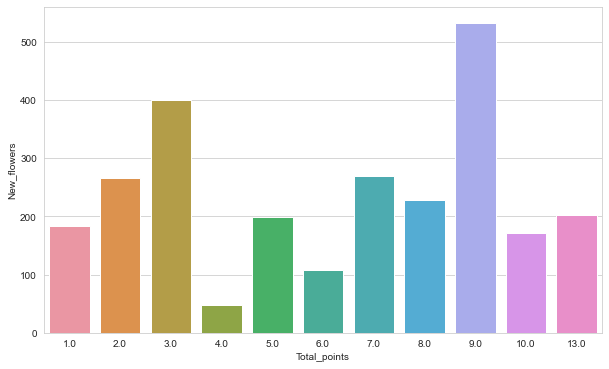

In [116]:
plt.figure(figsize=(10,6))
sns.barplot(x='Total_points', y='New_flowers',data=df3,estimator=sum, ci= False, )

### New flowers per day 

<AxesSubplot:xlabel='Total_points', ylabel='New_flowers'>

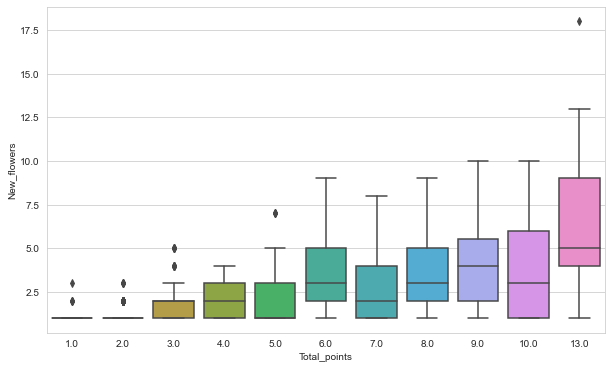

In [117]:
df3=df3.replace(0,np.nan)
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
sns.boxplot(data=df3,x='Total_points',y='New_flowers')

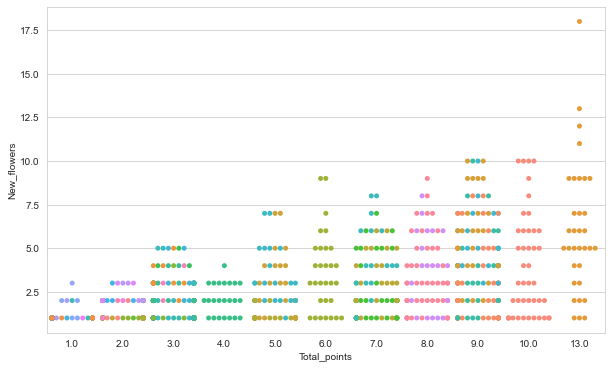

In [118]:
fig, ax = plt.subplots(figsize=(10,6))
g=sns.swarmplot(data=df3,x='Total_points',y='New_flowers', hue='Location')
g.get_legend().set_visible(False)

Each dot of a certain color represents the number of new flowers on a particular day by a paricular location.

### Count of vines

In [119]:
#Number of vines flowering for the year
n=len(df3['Location'].unique())
print("There are a total of", n ,"unique flowering locations")

There are a total of 50 unique flowering locations


<AxesSubplot:xlabel='Total_points'>

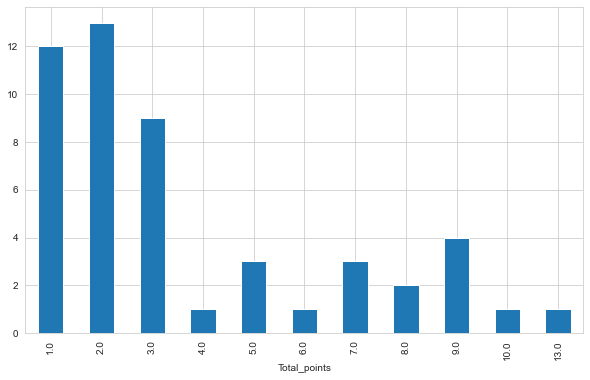

In [120]:
#Number of vines of a particular type
fig, ax = plt.subplots(figsize=(10,6))
df3.groupby(['Total_points'])['Location'].nunique().plot(kind='bar')

As we can see in the plot above, the majority of the vines are the 1,2, and 3 point vines.

### Days of flowering

In [121]:
# Identify locations which have count of '0' days of flowering. This is mostly because although the location 
#has been defined, it has no flowering days.
a=df3.groupby(['Total_points','Location'])['New_flowers'].count()
a=pd.DataFrame(a)
a.reset_index(inplace=True)
a.rename(columns={'New_flowers': 'Days'}, inplace=True)
a[a['Days']==0]

,Total_points,Location,Days


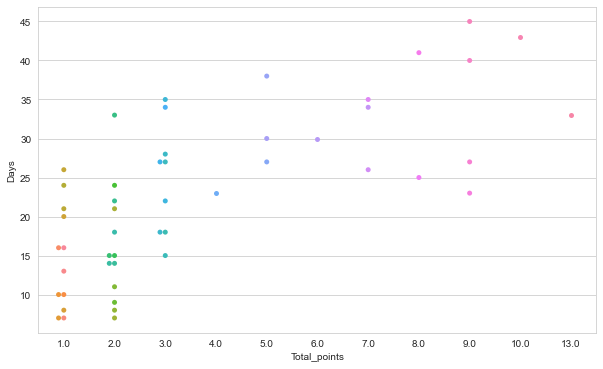

In [122]:
#Number of days of flowering by type
a=df3.groupby(['Total_points','Location'])['New_flowers'].count()
a=pd.DataFrame(a)
a.reset_index(inplace=True)
a.rename(columns={'New_flowers': 'Days'}, inplace=True)
fig, ax = plt.subplots(figsize=(10,6))
sns.swarmplot(data=a,x='Total_points',y='Days', hue='Location').get_legend().set_visible(False)

# Regression
- Intuitively, it feels like there may be a correlation between "points_flowering" (currently flowering) and number of new flowers for the day. 
- Explore possible patternality of new flower occurence:
    - a) as a group. Inference is likely common to all vines.
    - b) as an individual vine. Possible a factor of 'points_flowering' or specific other conditions.
 * We only have data of 'type' based on number of flowering points.

### Compare total flowers with type (Total_points)

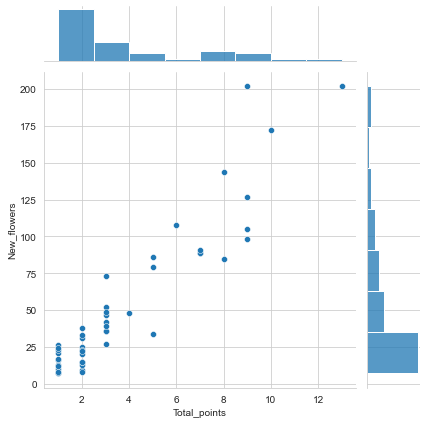

In [123]:
a=df3.groupby(['Location']).agg({
                         'Total_points': 'mean', 
                         'New_flowers':'sum', 
                          })
sns.jointplot(data=a,x='Total_points', y='New_flowers')

#### Clean up 'Points_flowering' column

In [124]:
# Convert 'Points_flowering' column to reflect only updated count
df4=df3.copy(deep=True) #save all previous transformations 
df4['Points_flowering']=df4['Points_flowering'].str.replace(' ','') #remove blank space in location column
df4['Points_flowering']=df4['Points_flowering'].str.replace('–','-') #format of dash made uniform
df4['Points_flowering']=df4['Points_flowering'].astype(str)
for ind,row in df4.iterrows():
    if '->' in row['Points_flowering']:
        df4.at[ind,'Points_flowering']=df4.loc[ind,'Points_flowering'].split('->')[1]

# Check if succesful        
df4[df4['Points_flowering'].str.contains('->', na=False)]

,Date,Location,Total_points,Points_flowering,New_flowers,Total_Flowers


In [125]:
df4[df4['Points_flowering'].str.contains('–>', na=False)]

,Date,Location,Total_points,Points_flowering,New_flowers,Total_Flowers


### Compare new flowers with points flowering on a given day
Note that a particualr vine may conain 2,3,4.. etc points actively fowering at different points in the season

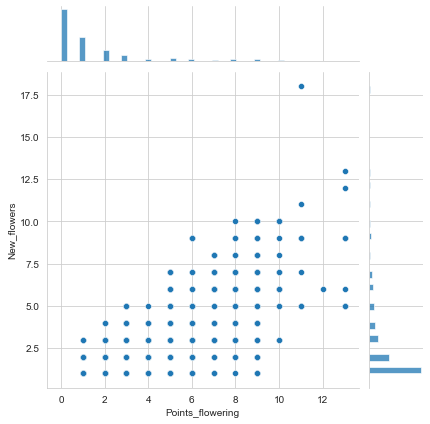

In [126]:
df4['Points_flowering']=df4['Points_flowering'].astype(float)
sns.jointplot(data=df4,x='Points_flowering', y='New_flowers')

In [127]:
#sns.pairplot(df4)

# Pareto of flowering

In [128]:
Loc_max=pd.DataFrame(df4.groupby('Location')['New_flowers'].sum())
Loc_max.sort_values(by='New_flowers',ascending=False, inplace=True )
Loc_max['Cum_sum']=Loc_max['New_flowers'].cumsum()
Loc_max['Cum_percentage']=Loc_max['Cum_sum']*100/Loc_max['New_flowers'].sum()
Loc_max.head()

,New_flowers,Cum_sum,Cum_percentage
Location,,,
5*4a,202.0,202.0,7.739464
4*3a2g,202.0,404.0,15.478927
4*3a,172.0,576.0,22.068966
3*2ag,144.0,720.0,27.586207
4*2a,127.0,847.0,32.452107


In [129]:
Loc_max.reset_index(inplace=True)
trace1 = dict(type='bar',
    x=Loc_max['Location'],
    y=Loc_max['New_flowers'],
    marker=dict(
        color='#2196F3'
    ),
    name='New_flowers',
    opacity=0.8
)

trace2 = dict(type='scatter',
    x=Loc_max['Location'],
    y=Loc_max['Cum_percentage'],
    marker=dict(
        color='#263238'
    ),
    line=dict(
        color= '#263238', 
        width= 1.5),
    name='Cumulative Percentage',
    xaxis='x1', 
    yaxis='y2' 
)


In [130]:
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
import plotly.graph_objs as go

In [131]:
data = [trace1, trace2]

layout = go.Layout(
    title='[Pareto Analysis of Total New Flowers by Locations',
    legend= dict(orientation="h"),
    
    yaxis=dict(
        range=[0,202],
        title='Total New Flowers',
        titlefont=dict(
            color="#2196F3"
        )
    ),
    yaxis2=dict(
        title='Cumulative Percentage of New Flowers ',
        titlefont=dict(
            color='#263238'
        ),
        range=[0,105],
        overlaying='y',
        anchor='x',
        side='right'
        )
    )



In [132]:
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename="pareto")

## Total number of new flowers

In [133]:
Total = df4['New_flowers'].sum()
print (Total)

2610.0


In [134]:
# Standard deviation
#df4[ "New_flowers"].fillna(0)
std_df = df4.groupby("Date")[ "New_flowers"].sum()
std_df.std()

35.541361203031926

In [135]:
std_df=

SyntaxError: invalid syntax (<ipython-input-135-9675d974a265>, line 1)

In [ ]:
#Total number of dates
n = len(pd.unique(df4['Date'])) 
  
print("No.of.unique values :",  
      n)

## What questions can be answered with improving year on year data:
**Data collection from drone-phase1 :**
* Inputs from a drone flight on a given day: 
    1. Number of locations- New ones may be discovered on some days
    2. Number of points_flowering(active)- if it has detected a flower once set 'active' flag
    3. Total number of new flowers.

**Immediate intelligence**
1. Best walking route to pollinate the flowers.
    
**Based on data gathered from previous years (from the data lake) we could possibly infer:**
* Where on the normal distribution curve we are, and hence:
    * Number of flowers which have been lost (previous dates)
    * Number of flowers which are yet to arrive in future.
    

